# カーネル密度推定（KDE）

In [120]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
import numpy as np
import itertools
from scipy.stats import gaussian_kde
from shapely.geometry import Point
from shapely.geometry import Polygon
from sklearn.preprocessing import MinMaxScaler

## GeoJSONの読込

In [121]:
crime_gdf = gpd.read_file("./geojson/aichi-crime-2020.geojson")
print(len(crime_gdf))
display(crime_gdf.head())

45456


,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",0.99,POINT (136.89271 35.20016)
1,crime-00002,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町２丁目,2019-08-05,18,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町2丁目",0.99,POINT (136.88114 35.20487)
2,crime-00003,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町３丁目,2019-05-23,08,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町3丁目",0.99,POINT (136.87985 35.20454)
3,crime-00004,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-10,17,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)
4,crime-00005,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-11,19,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)


In [122]:
# 信頼度0.8以上でフィルタ
crime_gdf = crime_gdf[crime_gdf["relevance"] > 0.8]
print(len(crime_gdf))
display(crime_gdf.head())

39351


,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",0.99,POINT (136.89271 35.20016)
1,crime-00002,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町２丁目,2019-08-05,18,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町2丁目",0.99,POINT (136.88114 35.20487)
2,crime-00003,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町３丁目,2019-05-23,08,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町3丁目",0.99,POINT (136.87985 35.20454)
3,crime-00004,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-10,17,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)
4,crime-00005,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-11,19,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (136.89937 35.20313)


In [123]:
# 直交座標系に変換
crime_gdf = crime_gdf.to_crs(epsg=6675)
print(len(crime_gdf))
display(crime_gdf.head())

39351


,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
0,crime-00001,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,天塚町４丁目,2019-09-11,20,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市西区天塚町4丁目",0.99,POINT (-24945.899 -88700.621)
1,crime-00002,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町２丁目,2019-08-05,18,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町2丁目",0.99,POINT (-25997.640 -88175.176)
2,crime-00003,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,上堀越町３丁目,2019-05-23,08,駐車（輪）場,"日本, 愛知県名古屋市西区上堀越町3丁目",0.99,POINT (-26115.092 -88210.778)
3,crime-00004,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-10,17,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (-24338.038 -88372.947)
4,crime-00005,窃盗,部品ねらい,西,名塚,231045,愛知県,名古屋市西区,香呑町１丁目,2019-03-11,19,駐車（輪）場,"日本, 愛知県名古屋市西区香呑町1丁目",0.99,POINT (-24338.038 -88372.947)


<AxesSubplot:>

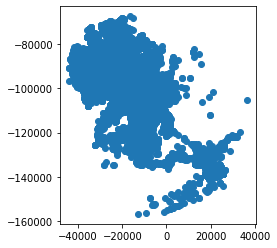

In [124]:
# 地図をプロット
crime_gdf.plot()

## 犯罪種別（trick）でグループ化

In [125]:
# 犯罪種別（trick）でグループ化
crime_trick_gdf = crime_gdf.groupby("trick").count()
trick_list = crime_trick_gdf.index.values
print(trick_list)

['ひったくり' 'オートバイ盗' '自動販売機ねらい' '自動車盗' '自転車盗' '車上ねらい' '部品ねらい']


In [126]:
# 辞書型で複数のデータフレームを記録
crime_gdf_dict = {}
crime_gdf_dict["全体"] = crime_gdf

# 犯罪種別でデータフレームを生成
for trick in trick_list:
    value_gdf = crime_gdf[crime_gdf["trick"] == trick]
    crime_gdf_dict[trick] = value_gdf
    
for key in crime_gdf_dict:
    print(f"{key}: {len(crime_gdf_dict[key])}")

全体: 39351
ひったくり: 234
オートバイ盗: 1593
自動販売機ねらい: 1278
自動車盗: 1693
自転車盗: 24857
車上ねらい: 5906
部品ねらい: 3790


## カーネル密度推定

In [127]:
bw_method_list = ["scott", "silverman", 0.5, 0.1, 0.05]

def crime_kde(gdf, bw_method):
    
    # 2次元配列に変換
    coord_list= []
    for g in gdf["geometry"].values:
        coord_list.append(list(g.coords)[0])

    coord_list = np.array(coord_list) # Numpyに変換
    coord_list = np.transpose(coord_list) # リストを転置
    kde = gaussian_kde(coord_list, bw_method=bw_method)
    
    return kde

## サンプルデータでカーネル密度推定

,id,crime,trick,police_station,police_box,city_code,prefecture,city,number,date,time,place,place_name,relevance,geometry
33659,crime-33660,窃盗,自動販売機ねらい,愛知,沓掛,232297,愛知県,豊明市,沓掛町城塚,2018-07-11,15,その他,"日本, 愛知県豊明市沓掛町城塚",0.99,POINT (-13420.925 -103087.677)
842,crime-00843,窃盗,部品ねらい,稲沢,下津,232203,愛知県,稲沢市,下津下町西３丁目,2019-01-17,08,駐車（輪）場,"日本, 愛知県稲沢市下津下町西3丁目",0.99,POINT (-30785.079 -83392.462)
21387,crime-21388,窃盗,自転車盗,瑞穂,弥富,231088,愛知県,名古屋市瑞穂区,中根町３丁目,2020/4/26,17,その他の住宅（３階建て以下共同住宅等）,"日本, 愛知県名古屋市瑞穂区中根町3丁目",0.99,POINT (-19354.351 -97949.930)
32330,crime-32331,窃盗,車上ねらい,守山,新守山駅前,231134,愛知県,名古屋市守山区,新守西,2018-10-11,20,その他,"日本, 愛知県名古屋市守山区新守西",0.99,POINT (-19726.035 -87715.677)
24330,crime-24331,窃盗,自転車盗,中,金山駅前,231061,愛知県,名古屋市中区,金山１丁目,2020/2/8,10,道路上,"日本, 愛知県名古屋市中区金山1丁目4番",0.99,POINT (-24060.856 -94650.818)


<AxesSubplot:>

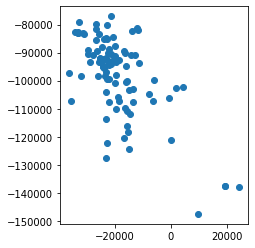

In [128]:
# サンプルを抽出(n=100)
n_sample = 100
sample_gdf = crime_gdf.sample(n_sample)
display(sample_gdf.head())
sample_gdf.plot()

In [129]:
# カーネル密度推定
bw_method = bw_method_list[0] # scott
kde = crime_kde(sample_gdf, bw_method=bw_method)

# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
print(kde.evaluate(target_geometry))

(2, 3)
[2.48957943e-89 1.06315217e-92 1.54262236e-09]


## 全データでカーネル密度推定

In [130]:
# カーネル密度推定
bw_method = bw_method_list[0] # scott
kde = crime_kde(crime_gdf, bw_method=bw_method)

# 任意のデータを外挿
target_geometry = np.array([(0, 0), (1000, 1000), (-20000, -90000)])
target_geometry = np.transpose(target_geometry)
print(target_geometry.shape)
print(kde.evaluate(target_geometry))

(2, 3)
[0.0000000e+00 0.0000000e+00 1.9002447e-09]


## 犯罪種別ごとにカーネル推定

In [131]:
trick_rename_dict = {
    "全体": "all",
    "ひったくり": "hittakuri",
    "オートバイ盗": "bike",
    "自動販売機ねらい": "jidou",
    "自動車盗": "jidousya",
    "自転車盗": "jitensya",
    "車上ねらい": "syajyou",
    "部品ねらい": "buhin"
}

band_rename_dict = {
    "scott": "scott",
    "silverman": "silverman",
    0.5: "050",
    0.1: "010",
    0.05: "005"
}

kde_dict = {}

for key in crime_gdf_dict:
    gdf = crime_gdf_dict[key]
    
    for bw_method in bw_method_list:
        trick_name = trick_rename_dict[key]
        band_name = band_rename_dict[bw_method]
        print(f"trick_name={trick_name} band_name={band_name}")
        
        # ファイル名をキーとして利用
        filename = f"crime-density-trick-{trick_name}-band-{band_name}"
        kde = crime_kde(gdf, bw_method=bw_method)
        kde_dict[filename] = kde

trick_name=all band_name=scott
trick_name=all band_name=silverman
trick_name=all band_name=050
trick_name=all band_name=010
trick_name=all band_name=005
trick_name=hittakuri band_name=scott
trick_name=hittakuri band_name=silverman
trick_name=hittakuri band_name=050
trick_name=hittakuri band_name=010
trick_name=hittakuri band_name=005
trick_name=bike band_name=scott
trick_name=bike band_name=silverman
trick_name=bike band_name=050
trick_name=bike band_name=010
trick_name=bike band_name=005
trick_name=jidou band_name=scott
trick_name=jidou band_name=silverman
trick_name=jidou band_name=050
trick_name=jidou band_name=010
trick_name=jidou band_name=005
trick_name=jidousya band_name=scott
trick_name=jidousya band_name=silverman
trick_name=jidousya band_name=050
trick_name=jidousya band_name=010
trick_name=jidousya band_name=005
trick_name=jitensya band_name=scott
trick_name=jitensya band_name=silverman
trick_name=jitensya band_name=050
trick_name=jitensya band_name=010
trick_name=jitensya b

## ヒートマップの生成

In [134]:
# GeoJSONに変換
def toGeoJSON(target_geometry, radius, density_list):
    
    radius_x = radius[0]
    radius_y = radius[1]
    
    geojson = {
        "type": "FeatureCollection",
        "features": []
    }

    features = []
    for (x,y),density in zip(target_geometry, density_list):
        #print(f"{x} {y} {density}")

        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [[[x-radius_x,  y-radius_y],[x+radius_x, y-radius_y],[x+radius_x, y+radius_y],[x-radius_x,  y+radius_y],[x-radius_x,  y-radius_y]]],
            },
            "properties": {
                "density": density,
            }
        }

        features.append(feature)

    geojson["features"] = features 
    
    return geojson

In [135]:
def crime_heatmap(kde, n_split=40):
    
    # 2次元配列に変換
    coord_list= []
    for g in gdf["geometry"].values:
        coord_list.append(list(g.coords)[0])

    coord_list = np.array(coord_list) # Numpyに変換
    coord_list = np.transpose(coord_list) # リストを転置
    
    # 分割
    min_x = np.min(coord_list[0])
    max_x = np.max(coord_list[0])
    min_y = np.min(coord_list[1])
    max_y = np.max(coord_list[1])
    x_range = np.linspace(min_x, max_x, n_split)
    y_range = np.linspace(min_y, max_y, n_split)
    
    # メッシュの1辺の距離
    length_x = np.abs(x_range[1] - x_range[0])
    length_y = np.abs(y_range[1] - y_range[0])
    radius_x = length_x / 2
    radius_y = length_y / 2
    radius = (radius_x, radius_y)
    
    # 計算対象の座標
    target_geometry = []
    for x, y in itertools.product(x_range, y_range):
        target_geometry.append((x, y))

    target_geometry = np.array(target_geometry)
    target_geometry = np.transpose(target_geometry)
    #print(f"target_geometry={target_geometry.shape}")
    
    # 密度
    density_list = kde.evaluate(target_geometry)
    #print(f"density={density_list}")
    
    # GeoJSONに変換
    target_geometry = np.transpose(target_geometry)
    geojson = toGeoJSON(target_geometry, radius, density_list)
    
    return geojson

In [136]:
# ヒートマップを生成
n_split = 40
geojson = crime_heatmap(kde, n_split)
print(geojson["features"][0])

# ヒートマップを保存
with open("./geojson/crime-density-2020.geojson", "w") as f:
    json.dump(geojson, f, ensure_ascii=False)

{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-43785.14493906315, -153817.2991057636], [-41830.072805478856, -153817.2991057636], [-41830.072805478856, -151661.72999746742], [-43785.14493906315, -151661.72999746742], [-43785.14493906315, -153817.2991057636]]]}, 'properties': {'density': 0.0}}


## 犯罪種別ごとにヒートマップを生成

In [151]:
for key in kde_dict:
    path = f"./geojson/{key}.geojson"
    kde = kde_dict[key]
    
    n_split = 40
    geojson = crime_heatmap(kde, n_split)
    
    with open(path, "w") as f:
        json.dump(geojson, f, ensure_ascii=False) 
        print(f"save as {path}")

save as ./geojson/crime-density-trick-all-band-scott.geojson
save as ./geojson/crime-density-trick-all-band-silverman.geojson
save as ./geojson/crime-density-trick-all-band-050.geojson
save as ./geojson/crime-density-trick-all-band-010.geojson
save as ./geojson/crime-density-trick-all-band-005.geojson
save as ./geojson/crime-density-trick-hittakuri-band-scott.geojson
save as ./geojson/crime-density-trick-hittakuri-band-silverman.geojson
save as ./geojson/crime-density-trick-hittakuri-band-050.geojson
save as ./geojson/crime-density-trick-hittakuri-band-010.geojson
save as ./geojson/crime-density-trick-hittakuri-band-005.geojson
save as ./geojson/crime-density-trick-bike-band-scott.geojson
save as ./geojson/crime-density-trick-bike-band-silverman.geojson
save as ./geojson/crime-density-trick-bike-band-050.geojson
save as ./geojson/crime-density-trick-bike-band-010.geojson
save as ./geojson/crime-density-trick-bike-band-005.geojson
save as ./geojson/crime-density-trick-jidou-band-scott.g

## GeoJSONの座標を緯度・経度（世界測地系）に変換

In [156]:
for key in kde_dict:
    path = f"./geojson/{key}.geojson"

    # GeoJSONの読込
    density_gdf = gpd.read_file(path)
    density_gdf = density_gdf.set_crs(epsg=6675, allow_override=True)
    
    # 緯度軽度に変換
    density_gdf = density_gdf.to_crs(epsg=4326)
    
    # ランクを生成
    rank_series = density_gdf["density"].rank(ascending=False)
    density_gdf["rank"] = rank_series  
    
    # GeoJSON形式で保存
    path = f"./geojson/{key}.js"
    density_gdf.to_file(path, driver='GeoJSON')    
    print(f"save as {path}")

save as ./geojson/crime-density-trick-all-band-scott.js
save as ./geojson/crime-density-trick-all-band-silverman.js
save as ./geojson/crime-density-trick-all-band-050.js
save as ./geojson/crime-density-trick-all-band-010.js
save as ./geojson/crime-density-trick-all-band-005.js
save as ./geojson/crime-density-trick-hittakuri-band-scott.js
save as ./geojson/crime-density-trick-hittakuri-band-silverman.js
save as ./geojson/crime-density-trick-hittakuri-band-050.js
save as ./geojson/crime-density-trick-hittakuri-band-010.js
save as ./geojson/crime-density-trick-hittakuri-band-005.js
save as ./geojson/crime-density-trick-bike-band-scott.js
save as ./geojson/crime-density-trick-bike-band-silverman.js
save as ./geojson/crime-density-trick-bike-band-050.js
save as ./geojson/crime-density-trick-bike-band-010.js
save as ./geojson/crime-density-trick-bike-band-005.js
save as ./geojson/crime-density-trick-jidou-band-scott.js
save as ./geojson/crime-density-trick-jidou-band-silverman.js
save as ./g

In [157]:
# 先頭に変数名を追加
for key in kde_dict:
    path = f"./geojson/{key}.js"
    data = ""
    
    with open(path, "r") as f:
        data = f.read()
        f.close()
        
    with open(path, "w") as f:
        var_name = key.replace("-", "_")
        update_data = f"let {var_name} = {data}"
        f.write(update_data)
        f.close()                
        
    print(f"update as {path}")

update as ./geojson/crime-density-trick-all-band-scott.js
update as ./geojson/crime-density-trick-all-band-silverman.js
update as ./geojson/crime-density-trick-all-band-050.js
update as ./geojson/crime-density-trick-all-band-010.js
update as ./geojson/crime-density-trick-all-band-005.js
update as ./geojson/crime-density-trick-hittakuri-band-scott.js
update as ./geojson/crime-density-trick-hittakuri-band-silverman.js
update as ./geojson/crime-density-trick-hittakuri-band-050.js
update as ./geojson/crime-density-trick-hittakuri-band-010.js
update as ./geojson/crime-density-trick-hittakuri-band-005.js
update as ./geojson/crime-density-trick-bike-band-scott.js
update as ./geojson/crime-density-trick-bike-band-silverman.js
update as ./geojson/crime-density-trick-bike-band-050.js
update as ./geojson/crime-density-trick-bike-band-010.js
update as ./geojson/crime-density-trick-bike-band-005.js
update as ./geojson/crime-density-trick-jidou-band-scott.js
update as ./geojson/crime-density-trick-j